# Подсчет доверительного интервала



Применили метод **bootstrap (n_s = 100.000, ci = 0.95) со scipy.stats**, с выводом среднего и 95% доверительного интервала. Получили результаты, представленные ниже:

```
без покрытия
ci_low,ci_high,mean
"55,747","62,711","59,12"
"53,985","58,989","56,25"
"43,932","51,262","46,79"
"56,787","61,845","59,15"
"42,413","48,495","44,71"
"47,828","53,109","50,46"
"62,789","65,6","64,17"
"61,302","64,036","62,61"
"57,276","63,406","60,58"
"50,535","55,977",53
"43,597","55,199","49,67"
"63,349","69,027","66,46"
"56,581","60,431","58,46"
"53,329","60,359","56,36"
"60,225","63,556","61,89"
"56,878","61,846","59,15"
"47,129","51,58","49,54"
"52,232","54,401","53,25"
"58,504","61,894","60,17"
"64,489","68,187","66,34"
"50,443","57,144","53,77"
"59,762","62,224","60,96"
"45,859","50,531","48,07"
"54,601","58,714","56,63"
"43,119","60,888","51,61"
"57,888","64,434","61,62"
"52,949","57,293",55
"60,177","64,087","62,07"
"55,93","59,769","57,73"
```

Результаты:
```
среднее ,"54,12534483","59,55151724"
макс-мин,"42,413","69,027"
```
**Решили брать:**
```
диапазон "43,473325" "67,301325"
внутри 2.5 до 97.5
```


# Поиск новых кандидатных регионов

Был написан скрипт поиска новых кандидатных регионов:



```
#!/usr/bin/env python3

import pandas as pd

def find_regions(bedmethyl_file, output_file, min_methylation=43, max_methylation=67, min_cpg=5, max_length=6000):
    df = pd.read_csv(bedmethyl_file, sep="\t", header=None)
    df.columns = [
    "chrom", "start", "end", "mod_code", "score", "strand",
    "start_compat", "end_compat", "color", "Nvalid_cov",
    "methylation_level", "Nmod", "Ncanonical", "Nother_mod",
    "Ndelete", "Nfail", "Ndiff", "N_local"]

    regions = []
    current_region = []
    current_chrom = None


    for index, row in df.iterrows():
        if current_chrom != row['chrom']:
            if current_region:
                regions.append(current_region)
            current_region = []
            current_chrom = row['chrom']


        if min_methylation <= row['methylation_level'] <= max_methylation:
            current_region.append(row)
        else:
            if len(current_region) >= min_cpg:
                regions.append(current_region)
            current_region = []


    if len(current_region) >= min_cpg:
        regions.append(current_region)


    filtered_regions = []
    for region in regions:
        start = region[0]['start']
        end = region[-1]['end']
        if end - start <= max_length:
            filtered_regions.append(region)


    with open(output_file, 'w') as f:
        f.write("chrom\tstart\tend\tcomputed_methylation_level\tall_methylation_levels\n")
        for region in filtered_regions:
            chrom = region[0]['chrom']
            start = region[0]['start']
            end = region[-1]['end']
            length = region[-1]['end'] - region[0]['start'] + 1
            methylation_levels = [r['methylation_level'] for r in region]
            computed_methylation_level = sum(methylation_levels) / len(methylation_levels)
            f.write(f"{chrom}\t{start}\t{end}\t{length}\t{computed_methylation_level}\t{','.join(map(str, methylation_levels))}\n")

bedmethyl_file = input()
output_file = 'candidate_dmrs.bed'
find_regions(bedmethyl_file, output_file)
```

**Пояснение: выбрана длина максимальная = 6000 (из максимальной длины контрольного региона), мин количество CpG в регионе >= 5, уровень метилирования в пределах ДИ** Фильтрацию по покрытию решила не проводить, потому что удаляются отдельные наблюдения (CpG) из  бедметил файла.


Получила в итоге сводную таблицу в пути (base)
/media/HEAP-EPI/Diplome_gi_Imanalieyva_Amina/hg_38_res/candidate_dmrs/candidate_dmrs.bed



```
chrom   start   end     methylation_level      all_methylation_levels
chr1    21418   21709   292     50.87625       61.34,53.4,47.52,43.42,52.1,52.99,52.47,43.77
chr1    270302  270413  112     54.852         59.07,48.93,61.88,53.78,50.6
chr1    377024  377053  30      52.266         46.32,45.27,48.98,60.18,60.58
chr1    377235  377265  31      54.876         59.13,51.24,56.98,57.65,49.38
chr1    619864  620545  682     58.512         61.56,65.04,58.04,56.82,51.1
chr1    844201  844711  511     55.326         64.67,45.51,51.08,60.18,55.19
chr1    898866  898976  111     55.33125       64.69,56.43,52.08,48.8,45.92,63.16,46.91,64.66
chr1    935542  935639  98      51.88   43.59,60.0,43.46,61.97,46.96,49.69,56.86,52.51
chr1    976776  976818  43      58.734  45.88,66.06,66.98,48.91,65.84

(base) root@eod-wgs:/media/HEAP-EPI/Diplome_gi_Imanalieyva_Amina/hg_38_res/candidate_dmrs# cat candidate_dmrs.bed | wc -l
11192
```





**11192 регионов у меня получилось.**

Обратила вниимание, что найдены и регионы с тем, что они добавляли от вирусов и тд тп, решила отфильтровать только с 1-22 хромосомы и половые. Получила следующее:


```
grep -E '^chr([1-9]|1[0-9]|2[0-2]|X|Y)[[:space:]]' candidate_dmrs.bed > map_of_dmrs.bed

10716 map_of_dmrs.bed


```



После я проверила эти регионы для валидации полученных результатов с контрольными регионами



```
(base) root@eod-wgs:/media/HEAP-EPI/Diplome_gi_Imanalieyva_Amina/hg_38_res/candidate_dmrs# cat intersect.bed
chr1    68046960        68046990        chr1    68046745        68047535        DIRAS3:Ex2-DMR (GNG12-AS1)
chr1    68047093        68047142        chr1    68046745        68047535        DIRAS3:Ex2-DMR (GNG12-AS1)
chr1    68047167        68047321        chr1    68046745        68047535        DIRAS3:Ex2-DMR (GNG12-AS1)
chr1    68049906        68050173        chr1    68047747        68051767        DIRAS3:TSS-DMR (GNG12-AS1)
chr1    68050254        68050661        chr1    68047747        68051767        DIRAS3:TSS-DMR (GNG12-AS1)
chr1    68050779        68051544        chr1    68047747        68051767        DIRAS3:TSS-DMR (GNG12-AS1)
chr1    68051649        68051706        chr1    68047747        68051767        DIRAS3:TSS-DMR (GNG12-AS1)
chr4    88697135        88697659        chr4    88697033        88698086        NAP1L5:TSS-DMR (HERC3)
chr4    88697886        88698085        chr4    88697033        88698086        NAP1L5:TSS-DMR (HERC3)
chr6    3848927 3849043 chr6    3848848 3850125 FAM50B:TSS DMR
chr6    3849092 3849177 chr6    3848848 3850125 FAM50B:TSS DMR
chr6    3849307 3849737 chr6    3848848 3850125 FAM50B:TSS DMR
chr6    3849815 3849884 chr6    3848848 3850125 FAM50B:TSS DMR
chr6    144006984       144007282       chr6    144006941       144008751       PLAGL1:alt-TSS DMR (HYMAI)
chr6    144007294       144007553       chr6    144006941       144008751       PLAGL1:alt-TSS DMR (HYMAI)
chr6    144007586       144007848       chr6    144006941       144008751       PLAGL1:alt-TSS DMR (HYMAI)
chr6    144008244       144008378       chr6    144006941       144008751       PLAGL1:alt-TSS DMR (HYMAI)
chr6    144008575       144008709       chr6    144006941       144008751       PLAGL1:alt-TSS DMR (HYMAI)
chr7    94656374        94656480        chr7    94656225        94658648        PEG10:TSS DMR
chr7    94656494        94657009        chr7    94656225        94658648        PEG10:TSS DMR
chr7    94657038        94657214        chr7    94656225        94658648        PEG10:TSS DMR
chr7    94657440        94657695        chr7    94656225        94658648        PEG10:TSS DMR
chr7    94657929        94658146        chr7    94656225        94658648        PEG10:TSS DMR
chr7    94658205        94658461        chr7    94656225        94658648        PEG10:TSS DMR
chr7    94658534        94658647        chr7    94656225        94658648        PEG10:TSS DMR
chr7    130490724       130490906       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130490917       130490977       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130491076       130491297       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130491416       130491634       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130492106       130492141       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130492306       130492335       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130492417       130492469       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130492481       130492765       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130492846       130493039       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    130493043       130493247       chr7    130490281       130494547       MEST:alt-TSS DMR
chr7    138664231       138664324       chr7    138663373       138664324       SVOPL:alt-TSS DMR
chr7    155071254       155071330       chr7    155071009       155071672       HTR5A:TSS DMR
chr7    155071449       155071499       chr7    155071009       155071672       HTR5A:TSS DMR
chr8    37748395        37748569        chr8    37747474        37748570        ERLIN2:Int6 DMR (LOC728024)
chr8    140098160       140098200       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140098240       140099096       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140099257       140099314       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140099377       140099604       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140099696       140100161       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140100214       140100467       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140100478       140100578       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140100647       140100705       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140100727       140100854       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr8    140100877       140100981       chr8    140098048       140100982       PEG13:TSS DMR (TRAPPC9)
chr9    95313405        95313435        chr9    95312864        95313633        FANCC:Int1 DMR
chr10   27413620        27413698        chr10   27413585        27414434        PTCHD3:TSS DMR
chr10   27413901        27413960        chr10   27413585        27414434        PTCHD3:TSS DMR
chr10   27414115        27414221        chr10   27413585        27414434        PTCHD3:TSS DMR
chr11   1998033 1998257 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   1998499 1998530 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   1998599 1998752 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   1999065 1999307 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   1999819 1999922 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   1999988 2000328 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2000427 2000717 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2000800 2001063 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2001091 2001518 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2001890 2001982 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2002051 2002167 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2002221 2002376 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2002518 2002584 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2002634 2002989 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2003049 2003197 chr11   1997582 2003510 H19/IGF2:IG - DMR
chr11   2148059 2148269 chr11   2147103 2148538 IGF2:alt-TSS-DMR
chr11   2148429 2148538 chr11   2147103 2148538 IGF2:alt-TSS-DMR
chr11   2699813 2699907 chr11   2699682 2700531 KCNQ1OT1
chr13   48318400        48318507        chr13   48318205        48321627        RB1:Int-DMR
chr13   48318552        48319417        chr13   48318205        48321627        RB1:Int-DMR
chr13   48319426        48319642        chr13   48318205        48321627        RB1:Int-DMR
chr13   48319663        48320016        chr13   48318205        48321627        RB1:Int-DMR
chr13   48320048        48320133        chr13   48318205        48321627        RB1:Int-DMR
chr13   48320221        48320293        chr13   48318205        48321627        RB1:Int-DMR
chr13   48320634        48321105        chr13   48318205        48321627        RB1:Int-DMR
chr15   24954857        24954908        chr15   24954857        24956829        SNURF:TSS DMR (SNRPN)
chr15   24955034        24955106        chr15   24954857        24956829        SNURF:TSS DMR (SNRPN)
chr15   24955233        24955273        chr15   24954857        24956829        SNURF:TSS DMR (SNRPN)
chr15   24955285        24955343        chr15   24954857        24956829        SNURF:TSS DMR (SNRPN)
chr15   24955440        24955546        chr15   24954857        24956829        SNURF:TSS DMR (SNRPN)
chr15   24956365        24956495        chr15   24954857        24956829        SNURF:TSS DMR (SNRPN)
chr15   24956546        24956605        chr15   24954857        24956829        SNURF:TSS DMR (SNRPN)
chr15   98865267        98865428        chr15   98865267        98866421        IGF1R:Int2-DMR
chr15   98865720        98866012        chr15   98865267        98866421        IGF1R:Int2-DMR
chr15   98866043        98866220        chr15   98865267        98866421        IGF1R:Int2-DMR
chr16   3431801 3431926 chr16   3431801 3432388 ZNF597: 3-DMR
chr16   3431937 3432078 chr16   3431801 3432388 ZNF597: 3-DMR
chr16   3432116 3432387 chr16   3431801 3432388 ZNF597: 3-DMR
chr19   53537256        53537441        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53537581        53537666        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53537809        53537856        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53537888        53538075        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53538106        53538171        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53538247        53538292        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53538318        53538486        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53538620        53538821        chr19   53537256        53538958        ZNF331:alt-TSS DMR1
chr19   53553857        53554163        chr19   53553832        53555171        ZNF331:alt-TSS DMR2
chr19   53554195        53554310        chr19   53553832        53555171        ZNF331:alt-TSS DMR2
chr19   53554337        53554380        chr19   53553832        53555171        ZNF331:alt-TSS DMR2
chr19   53554468        53554572        chr19   53553832        53555171        ZNF331:alt-TSS DMR2
chr19   53554777        53554834        chr19   53553832        53555171        ZNF331:alt-TSS DMR2
chr19   56837587        56837808        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56837846        56838020        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56838159        56838440        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56838547        56838816        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56839010        56839059        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56839074        56839478        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56839548        56839779        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56839915        56839998        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56840082        56840327        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56840682        56840774        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56840842        56840915        chr19   56837125        56841903        PEG3:TSS-DMR
chr19   56841034        56841355        chr19   56837125        56841903        PEG3:TSS-DMR
chr20   31547004        31547355        chr20   31546860        31548130        MCTS2P:TSS DMR (HM13)
chr20   31547448        31548129        chr20   31546860        31548130        MCTS2P:TSS DMR (HM13)
chr20   43513725        43513964        chr20   43513725        43515400        L3MBTL1:alt TSS-DMR
chr20   43514507        43514733        chr20   43513725        43515400        L3MBTL1:alt TSS-DMR
chr20   43514753        43514826        chr20   43513725        43515400        L3MBTL1:alt TSS-DMR
chr20   43514949        43515175        chr20   43513725        43515400        L3MBTL1:alt TSS-DMR
chr20   58850682        58850807        chr20   58850594        58852978        GNAS-AS1:TSS DMR
chr20   58851208        58851694        chr20   58850594        58852978        GNAS-AS1:TSS DMR
chr20   58851886        58851991        chr20   58850594        58852978        GNAS-AS1:TSS DMR
chr20   58853994        58854032        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58854151        58854204        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58854476        58854540        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58854824        58854884        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58854950        58855002        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58855128        58855356        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58855534        58855618        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58855878        58855978        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr20   58856078        58856183        chr20   58853850        58856408        GNAS-XL:Ex1 DMR
chr21   39385862        39385960        chr21   39385584        39386350        WRB:alt-TSS DMR
chr21   39385972        39386105        chr21   39385584        39386350        WRB:alt-TSS DMR
chr22   41681770        41682076        chr22   41681770        41682869        SNU13:alt-TSS DMR
chr22   41682126        41682228        chr22   41681770        41682869        SNU13:alt-TSS DMR
chr22   41682742        41682869        chr22   41681770        41682869        SNU13:alt-TSS DMR
```



Все контрольные регионы совпали по пересечению, но несколько раз.

Мне покзаалось это логичным, потому что мы не знаем точных координат DMR (в статьях представлено образно), плюс у меня собирались "корзинки" для кандидатных DMR и он мог их группировать как поменьше, так побольше по длине. Думаю как их отфильтровать, но убирать не стала. Плюс ко всему, это значит, что регионов где-то в 5 раз меньше, если будем брать в счет, что в среднем каждый регион попадался 2-3 раза. (137 пересечений для 29 регионов)

Я решила для валидации посчитать отдельно представленные координаты в **modkit stats**

```
(base) root@eod-wgs:/media/HEAP-EPI/Diplome_gi_Imanalieyva_Amina/hg_38_res/candidate_dmrs# head modkit_candidate.csv
chrom   start   end     name    strand  count_m count_valid_m   percent_m
chr1    270302  270413  .       .       1513    2769    54.640663
chr1    377024  377053  .       .       333     648     51.38889
chr1    377235  377265  .       .       268     488     54.918034
chr1    619864  620545  .       .       1141    1946    58.633095
chr1    844201  844711  .       .       787     1380    57.028984
chr1    898866  898976  .       .       1615    2928    55.1571
chr1    935542  935639  .       .       1290    2500    51.6
chr1    976776  976818  .       .       441     715     61.67832
chr1    1014336 1014437 .       .       1091    1996    54.659317

```
Все регионы по уровню метилирования лежали также в пределах ДИ. Меня это порадовало. Пока мы ждем оксану, я решила посмотреть на **характеристики представленных кандидатных DMR и близлежайшие транскрипты**



# Кандидатные DMR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/метилирование.tsv', sep='\t')
df.columns = ['chrom', 'start', 'end', 'imprint_status']

<ipython-input-21-db2fa7762e3a>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['length'], bins=50, kde=True, palette = 'crest', label='Распределение  кандидатных ICR ')


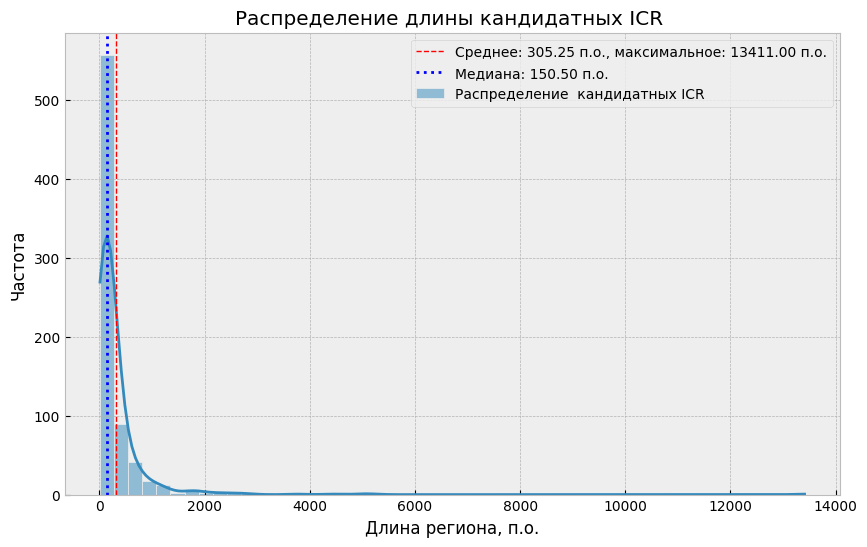

In [ ]:

df['length'] = df['end'] - df['start'] +1
df = df[df['length'] >= 5]
plt.figure(figsize=(10, 6))
plt.style.use('bmh')

sns.histplot(df['length'], bins=50, kde=True, palette = 'crest', label='Распределение  кандидатных ICR ')
mean_length = df['length'].mean()
minimum = df['length'].min()
maximum = df['length'].max()
plt.axvline(mean_length, color='red', linestyle='--', linewidth=1, label=f'Среднее: {mean_length:.2f} п.о., максимальное: {maximum:.2f} п.о.')
median_length = df['length'].median()
plt.axvline(median_length, color='blue', linestyle=':', linewidth=2, label=f'Медиана: {median_length:.2f} п.о.')
plt.title('Распределение длины кандидатных ICR ')
plt.xlabel('Длина региона, п.о.')
plt.ylabel('Частота')

plt.legend()
plt.show()

<ipython-input-51-9187fb24c866>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='chrom', y='percent_m', data=df, palette = 'crest')


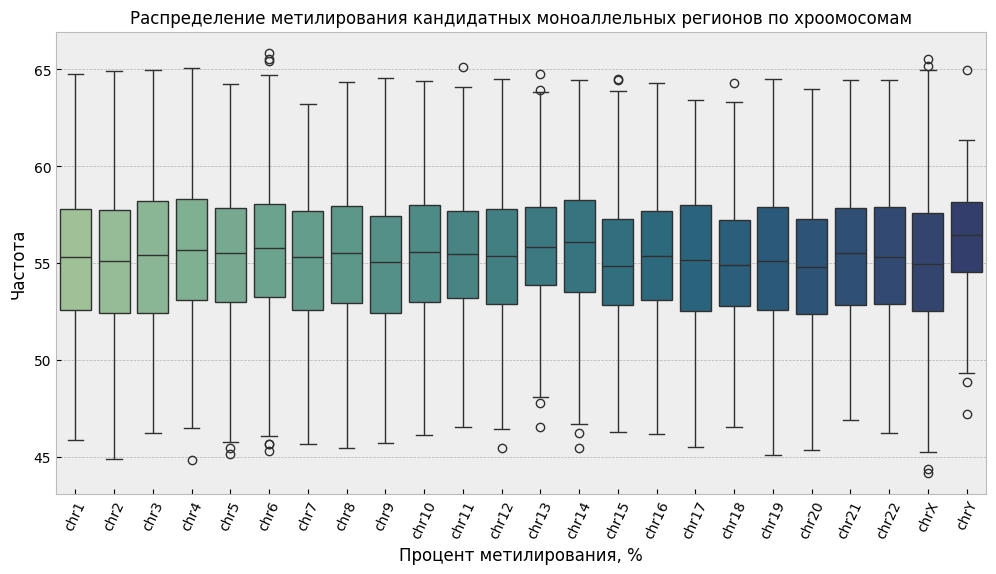

In [ ]:

plt.figure(figsize=(12, 6))
plt.style.use("bmh")

sns.boxplot(x='chrom', y='percent_m', data=df, palette = 'crest')
plt.title('Распределение метилирования кандидатных моноаллельных регионов по хроомосомам', fontsize = 12)
plt.xlabel('Процент метилирования, %')
plt.ylabel('Частота')
plt.xticks(rotation=65)
sns.color_palette("crest", as_cmap=True)

plt.show()

# Анализ близлежайших транскриптов


In [ ]:
! pip install "numpy<2" # с выше он не работает кста, поэтому я уменьшила

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
! pip install pyensembl

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 537.2/537.2 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 8.6 MB/s eta 0:00:00
  Created wheel for memoized-property: filename=memoized_property-1.0.3-py2.py3-none-any.whl size=4186 sha256=2ca421a76d01f14cb6616afaeddc711d3a31d4c63d8948dca68911d6cce6a51e
  Stored in directory: /root/.cache/pip/wheels/9f/b0/46/efa2c4a4875990b1467f5ed29dd8983eda2144c5b8be9441a2
  Created wheel for tinytimer: filename=tinytimer-0.0.0-py3-none-any.whl size=1

In [ ]:
! pyensembl install --release 110 --species homo_sapiens

2025-05-16 12:18:03,921 - pyensembl.shell - INFO - Running 'install' for EnsemblRelease(release=110, species='homo_sapiens')
2025-05-16 12:18:03,921 - pyensembl.download_cache - INFO - Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz from URL https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz
2025-05-16 12:18:03,921 - datacache.download - INFO - Downloading https://ftp.ensembl.org/pub/release-110/gtf/homo_sapiens/Homo_sapiens.GRCh38.110.gtf.gz to /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.110.gtf.gz
2025-05-16 12:18:06,758 - pyensembl.download_cache - INFO - Fetching /root/.cache/pyensembl/GRCh38/ensembl110/Homo_sapiens.GRCh38.cdna.all.fa.gz from URL https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.all.fa.gz
2025-05-16 12:18:06,758 - datacache.download - INFO - Downloading https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/cdna/Homo_sapiens.GRCh38.cdna.

In [ ]:
import pyensembl
import pandas as pd

ensembl = pyensembl.EnsemblRelease(release=110)  # релиз, я тупо загуглила и другого не нашла
print("Загружены аннотации для сборки:", pyensembl.ensembl_grch38)

def find_nearest_transcript(chrom, start, end):
    chrom = chrom.replace("chr", "")  # у энсэмбл без хром
    transcripts = ensembl.transcripts_at_locus(chrom, start, end)
    if not transcripts:
        return None
    #  первый транскрипт и его цепь
    return transcripts[0], transcripts[0].strand, transcripts[0].biotype

file_path = "/content/метилирование.tsv"
data = pd.read_csv(file_path, sep="\t")
data.columns = ['chrom', 'start', 'end', 'imprint_status']
results = []

for index, row in data.iterrows():
    chrom = row["chrom"]
    start = row["start"]
    end = row["end"]

    print(f"\nРегион: {chrom}:{start}-{end}")

    nearest_transcript_info = find_nearest_transcript(chrom, start, end)
    if nearest_transcript_info is not None:
        nearest_transcript, strand, biotype = nearest_transcript_info
        print("Ближайший транскрипт:")
        print(f"ID: {nearest_transcript.transcript_id}")
        print(f"Ген: {nearest_transcript.gene_name}")
        print(f"Биотип: {biotype}")
        print(f"Цепь: {strand}")

        results.append([chrom, start, end, nearest_transcript.transcript_id,
                       nearest_transcript.gene_name, strand, biotype])
    else:
        print("Транскрипт не найден.")
        # регион без транскрипта
        results.append([chrom, start, end, "N/A", "N/A", "N/A", "N/A"])

results_df = pd.DataFrame(results, columns=["chrom", "start", "end", "transcript_id",
                                           "gene_name", "strand", "biotype"])
output_file = "icrs_nearest_tr.csv"
results_df.to_csv(output_file, index=False)

print(f"Результаты сохранены в файл: {output_file}")

Загружены аннотации для сборки: EnsemblRelease(release=110, species='homo_sapiens')

Регион: chr1:108660645-108660690
Ближайший транскрипт:
ID: ENST00000370031
Ген: HENMT1
Биотип: protein_coding
Цепь: -

Регион: chr1:109087481-109087666
Транскрипт не найден.

Регион: chr1:111708011-111708068
Ближайший транскрипт:
ID: ENST00000356415
Ген: RAP1A
Биотип: protein_coding
Цепь: +

Регион: chr1:120388480-120388696
Транскрипт не найден.

Регион: chr1:121397143-121397183
Ближайший транскрипт:
ID: ENST00000417218
Ген: LINC02798
Биотип: lncRNA
Цепь: +

Регион: chr1:12177741-12177850
Ближайший транскрипт:
ID: ENST00000376259
Ген: TNFRSF1B
Биотип: protein_coding
Цепь: +

Регион: chr1:1430685-1430818
Ближайший транскрипт:
ID: ENST00000417917
Ген: LINC01770
Биотип: lncRNA
Цепь: -

Регион: chr1:1438100-1438258
Ближайший транскрипт:
ID: ENST00000338660
Ген: VWA1
Биотип: protein_coding
Цепь: +

Регион: chr1:147077108-147077272
Транскрипт не найден.

Регион: chr1:149711749-149712939
Ближайший транскрипт:

Находятся близлежайший транскрипт, например как в контрольных:

```
(meth_level) aimanalieva@eod-wgs:/media/HEAP-EPI/Diplome_gi_Imanalieyva_Amina/hg_38_res/candidate_dmrs$ cat nearest_tr.csv |  grep 'H19'
chr11,1998033,1998257,ENST00000422826,H19,-,lncRNA
chr11,1998499,1998530,ENST00000422826,H19,-,lncRNA
chr11,1998599,1998752,ENST00000422826,H19,-,lncRNA
chr11,1999065,1999307,ENST00000422826,H19,-,lncRNA
chr11,1999819,1999922,ENST00000422826,H19,-,lncRNA
chr11,1999988,2000328,ENST00000422826,H19,-,lncRNA
chr11,2000427,2000717,ENST00000422826,H19,-,lncRNA
chr11,2000800,2001063,ENST00000422826,H19,-,lncRNA
chr11,2001091,2001518,ENST00000422826,H19,-,lncRNA
chr11,2001890,2001982,ENST00000710497,H19,-,lncRNA
chr11,2002051,2002167,ENST00000710497,H19,-,lncRNA
chr11,2002221,2002376,ENST00000710497,H19,-,lncRNA
chr11,2002518,2002584,ENST00000710497,H19,-,lncRNA
chr11,2002634,2002989,ENST00000710497,H19,-,lncRNA
chr11,2003049,2003197,ENST00000710497,H19,-,lncRNA
chrX,100296325,100296541,ENST00000255531,PCDH19,-,protein_coding
chrX,100406760,100406782,ENST00000255531,PCDH19,-,protein_coding
chrX,100408674,100408696,ENST00000373034,PCDH19,-,protein_coding
chrX,100409293,100409358,ENST00000373034,PCDH19,-,protein_coding
chrX,100410202,100410233,ENST00000373034,PCDH19,-,protein_coding
(meth_level) aimanalieva@eod-wgs:/media/HEAP-EPI/Diplome_gi_Imanalieyva_Amina/hg_38_res/candidate_dmrs$ cat nearest_tr.csv |  grep 'KCNQ1'
chr11,2511220,2511525,ENST00000155840,KCNQ1,+,protein_coding
chr11,2698856,2699289,ENST00000155840,KCNQ1,+,protein_coding
chr11,2699470,2699595,ENST00000155840,KCNQ1,+,protein_coding
chr11,2699813,2699907,ENST00000155840,KCNQ1,+,protein_coding
chr11,2792124,2792201,ENST00000155840,KCNQ1,+,protein_coding
chr11,2870008,2870039,ENST00000441418,KCNQ1DN,+,lncRNA
(meth_level) aimanalieva@eod-wgs:/media/HEAP-EPI/Diplome_gi_Imanalieyva_Amina/hg_38_res/candidate_dmrs$ cat nearest_tr.csv |  grep 'FAM50B'
chr6,3849307,3849737,ENST00000380274,FAM50B,+,protein_coding
chr6,3849815,3849884,ENST00000380274,FAM50B,+,protein_coding
```



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv('/content/icrs_nearest_tr.csv')
df1 = df.drop_duplicates(subset=['gene_name'])
df1

,chrom,start,end,transcript_id,gene_name,strand,biotype
0,chr1,108660645,108660690,ENST00000370031,HENMT1,-,protein_coding
1,chr1,109087481,109087666,NaN,NaN,NaN,NaN
2,chr1,111708011,111708068,ENST00000356415,RAP1A,+,protein_coding
4,chr1,121397143,121397183,ENST00000417218,LINC02798,+,lncRNA
5,chr1,12177741,12177850,ENST00000376259,TNFRSF1B,+,protein_coding
...,...,...,...,...,...,...,...
718,chr9,33777501,33777632,ENST00000342836,PRSS3,+,protein_coding
719,chr9,35846486,35846535,ENST00000377988,TMEM8B,+,protein_coding
728,chr9,61854737,61856632,ENST00000377542,FAM27C,+,lncRNA
732,chr9,64488650,64488699,ENST00000456472,GXYLT1P6,+,processed_pseudogene


<ipython-input-42-7223136d9e58>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=biotype_counts.values, y=biotype_counts.index, palette = 'crest')


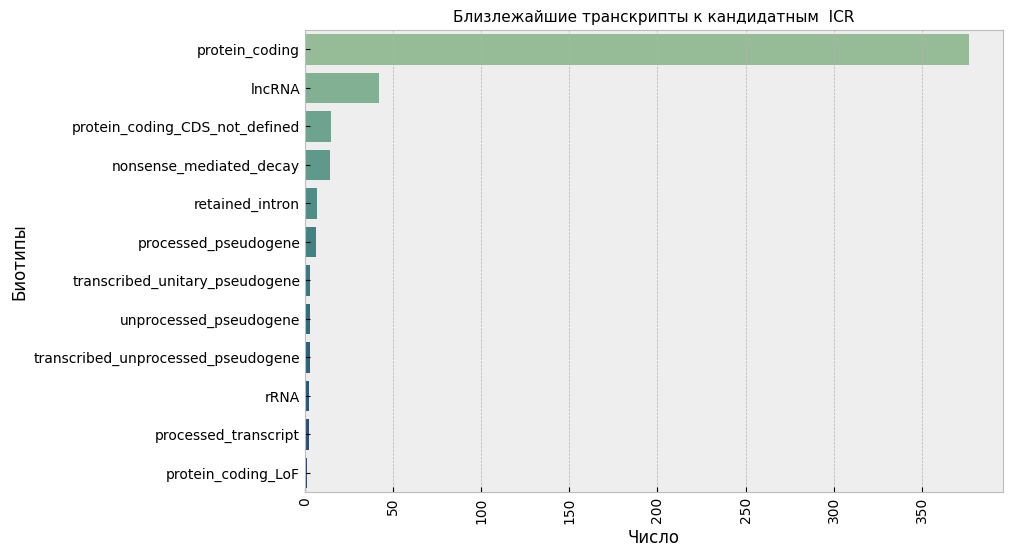

In [ ]:
biotype_counts = df1['biotype'].value_counts()

plt.figure(figsize=(9, 6))
plt.style.use("bmh")

sns.barplot(x=biotype_counts.values, y=biotype_counts.index, palette = 'crest')
plt.xticks(rotation=90)
plt.xlabel('Число')
plt.ylabel('Биотипы')
plt.title('Близлежайшие транскрипты к кандидатным  ICR', fontsize = 11)
plt.show()

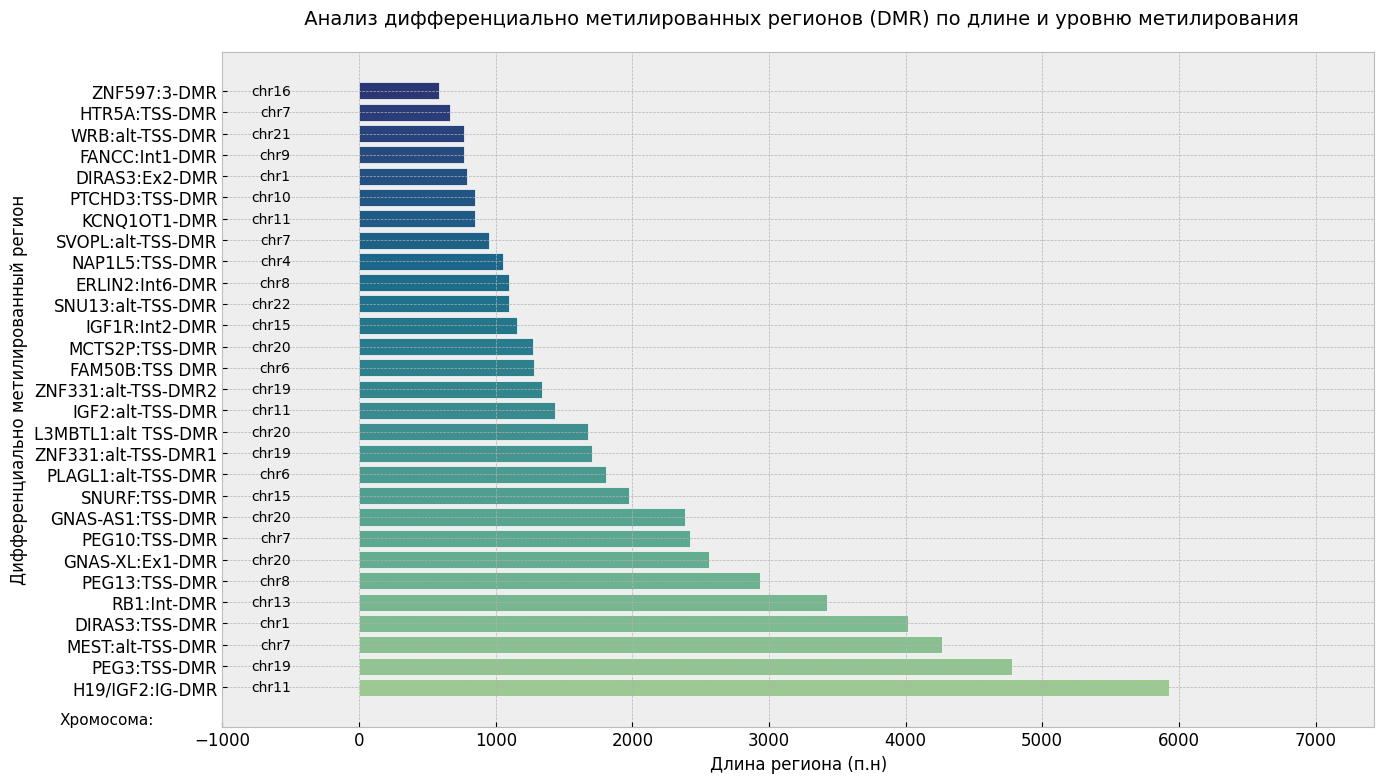

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Устанавливаем стиль
plt.style.use('bmh')
sns.set_palette("crest")

# Создаем DataFrame с данными
data = {
    'DMR': ["DIRAS3:TSS-DMR", "DIRAS3:Ex2-DMR", "NAP1L5:TSS-DMR", "FAM50B:TSS DMR",
            "PLAGL1:alt-TSS-DMR", "PEG10:TSS-DMR", "MEST:alt-TSS-DMR", "SVOPL:alt-TSS-DMR",
            "HTR5A:TSS-DMR", "ERLIN2:Int6-DMR", "PEG13:TSS-DMR", "FANCC:Int1-DMR",
            "PTCHD3:TSS-DMR", "H19/IGF2:IG-DMR", "IGF2:alt-TSS-DMR", "KCNQ1OT1-DMR",
            "RB1:Int-DMR", "SNURF:TSS-DMR", "IGF1R:Int2-DMR", "ZNF597:3-DMR",
            "ZNF331:alt-TSS-DMR1", "PEG3:TSS-DMR", "ZNF331:alt-TSS-DMR2", "MCTS2P:TSS-DMR",
            "L3MBTL1:alt TSS-DMR", "GNAS-AS1:TSS-DMR", "GNAS-XL:Ex1-DMR", "WRB:alt-TSS-DMR",
            "SNU13:alt-TSS-DMR"],
    'Chromosome': ["chr1", "chr1", "chr4", "chr6", "chr6", "chr7", "chr7", "chr7",
                  "chr7", "chr8", "chr8", "chr9", "chr10", "chr11", "chr11", "chr11",
                  "chr13", "chr15", "chr15", "chr16", "chr19", "chr19", "chr19", "chr20",
                  "chr20", "chr20", "chr20", "chr21", "chr22"],
    'Start': [68047747, 68046745, 88697033, 3848848, 144006941, 94656225, 130490281, 138663373,
             155071009, 37747474, 140098048, 95312864, 27413585, 1997582, 2147103, 2699682,
             48318205, 24954857, 98865267, 3431801, 53537256, 56837125, 53553832, 31546860,
             43513725, 58850594, 58853850, 39385584, 41681770],
    'End': [68051767, 68047535, 88698086, 3850125, 144008751, 94658648, 130494547, 138664324,
           155071672, 37748570, 140100982, 95313633, 27414434, 2003510, 2148538, 2700531,
           48321627, 24956829, 98866421, 3432388, 53538958, 56841903, 53555171, 31548130,
           43515400, 58852978, 58856408, 39386350, 41682869],
    'Methylation': [54.17, 56.79, 54.41, 57.34, 54.61, 48.6, 53.61, 47.91, 59.46, 46.6, 52.05,
                   43.76, 47.72, 43.38, 49.15, 52.58, 56.47, 48.43, 48.74, 56.84, 55.37, 52.44,
                   48.2, 52.46, 52.18, 45.75, 56.16, 59.42, 45.04]
}

df = pd.DataFrame(data)
df['Length'] = df['End'] - df['Start']
df['Gene'] = df['DMR'].str.split(':').str[0]

# Сортируем по длине
df = df.sort_values('Length', ascending=False)

# Создаем фигуру
plt.figure(figsize=(14, 8))

# Создаем barplot с длинами DMR
bars = plt.barh(df['DMR'], df['Length'],
                color=sns.color_palette("crest", n_colors=len(df)),
                edgecolor='white')

# Добавляем хромосомную информацию
for i, chrom in enumerate(df['Chromosome']):
    plt.text(-500, i, chrom, ha='right', va='center', fontsize=10)

# Настройки графика
plt.title(' Анализ дифференциально метилированных регионов (DMR) по длине и уровню метилирования',
          fontsize=14, pad=20)
plt.xlabel('Длина региона (п.н)', fontsize=12)
plt.ylabel('Дифференциально метилированный регион', fontsize=12)
plt.xlim(-1000, df['Length'].max() + 1500)

# Хромосомная подпись
plt.text(-1500, -1.5, 'Хромосома:', ha='right', va='center', fontsize=11)

plt.tight_layout()
plt.show()


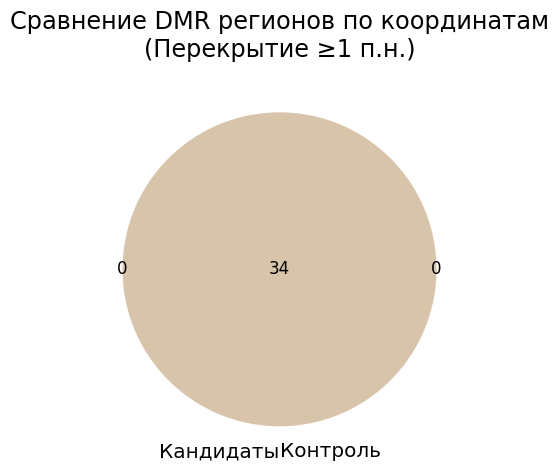


Статистика:
Всего регионов: 34
Полное вхождение: 34
Частичное перекрытие: 0
Без перекрытия: 0

Примеры регионов с полным вхождением:
          Регион  Кандидат старт  Кандидат конец  Контроль старт  Контроль конец
  DIRAS3:Ex2-DMR        68046960        68047321        68046745        68047535
  DIRAS3:TSS-DMR        68049906        68051706        68047747        68051767
JAKMIP1:Int2-DMR         6105223         6105790         6104867         6106458
  NAP1L5:TSS-DMR        88697135        88698085        88697033        88698086
  FAM50B:TSS DMR         3848927         3849884         3848848         3850125


In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd

# Загрузка данных
data = {
    'Регион': ["DIRAS3:Ex2-DMR", "DIRAS3:TSS-DMR", "JAKMIP1:Int2-DMR",
              "NAP1L5:TSS-DMR", "FAM50B:TSS DMR", "PLAGL1:alt-TSS DMR",
              "WDR27:Int13-DMR", "GRB10:alt-TSS DMR", "PEG10:TSS DMR",
              "MEST:alt-TSS DMR", "SVOPL:alt-TSS DMR", "HTR5A:TSS DMR",
              "ERLIN2:Int6 DMR", "PEG13:TSS DMR", "FANCC:Int1 DMR",
              "PTCHD3:TSS DMR", "H19/IGF2:IG - DMR", "IGF2:alt-TSS-DMR",
              "KCNQ1OT1", "RB1:Int-DMR", "SNURF:TSS DMR", "IGF1R:Int2-DMR",
              "ZNF597: 3-DMR", "ZNF331:alt-TSS DMR1", "ZNF331:alt-TSS DMR2",
              "PEG3:TSS-DMR", "MCTS2P:TSS DMR", "NNAT:TSS-DMR",
              "L3MBTL1:alt TSS-DMR", "GNAS-AS1:TSS DMR", "GNAS-XL:Ex1 DMR",
              "GNAS A/B:TSS DMR", "WRB:alt-TSS DMR", "SNU13:alt-TSS DMR"],
    'Кандидат старт': [68046960, 68049906, 6105223, 88697135, 3848927, 144006984,
                      169654498, 50782107, 94656374, 130490724, 138664231, 155071254,
                      37748395, 140098160, 95313405, 27413620, 1998033, 2148059,
                      2699682, 48318400, 24954857, 98865267, 3431801, 53537256,
                      53553857, 56837587, 31547004, 37521353, 43513725, 58850682,
                      58853994, 58888341, 39385862, 41681770],
    'Кандидат конец': [68047321, 68051706, 6105790, 88698085, 3849884, 144008709,
                      169655220, 50783354, 94658647, 130493247, 138664324, 155071499,
                      37748569, 140100981, 95313435, 27414221, 2003197, 2148538,
                      2699907, 48321105, 24956605, 98866220, 3432387, 53538821,
                      53554834, 56841355, 31548129, 37522031, 43515175, 58851991,
                      58856183, 58890145, 39386105, 41682869],
    'Контроль старт': [68046745, 68047747, 6104867, 88697033, 3848848, 144006941,
                      169654408, 50781029, 94656225, 130490281, 138663373, 155071009,
                      37747474, 140098048, 95312864, 27413585, 1997582, 2147103,
                      2699682, 48318205, 24954857, 98865267, 3431801, 53537256,
                      53553832, 56837125, 31546860, 37520202, 43513725, 58850594,
                      58853850, 58888210, 39385584, 41681770],
    'Контроль конец': [68047535, 68051767, 6106458, 88698086, 3850125, 144008751,
                      169655522, 50783615, 94658648, 130494547, 138664324, 155071672,
                      37748570, 140100982, 95313633, 27414434, 2003510, 2148538,
                      2700531, 48321627, 24956829, 98866421, 3432388, 53538958,
                      53555171, 56841903, 31548130, 37522126, 43515400, 58852978,
                      58856408, 58890146, 39386350, 41682869]
}

df = pd.DataFrame(data)

# Рассчитываем длины
df['Длина кандидата'] = df['Кандидат конец'] - df['Кандидат старт']
df['Длина контроля'] = df['Контроль конец'] - df['Контроль старт']

# Функция для определения перекрытия регионов
def check_overlap(row):
    # Проверяем полное вхождение кандидата в контроль
    if (row['Кандидат старт'] >= row['Контроль старт']) and \
       (row['Кандидат конец'] <= row['Контроль конец']):
        return 'Полное вхождение'
    # Проверяем частичное перекрытие
    elif ((row['Кандидат старт'] <= row['Контроль конец']) and \
         (row['Кандидат конец'] >= row['Контроль старт'])):
        return 'Частичное перекрытие'
    else:
        return 'Нет перекрытия'

df['Тип перекрытия'] = df.apply(check_overlap, axis=1)

# Группируем регионы по типу
full_overlap = df[df['Тип перекрытия'] == 'Полное вхождение']
partial_overlap = df[df['Тип перекрытия'] == 'Частичное перекрытие']
no_overlap = df[df['Тип перекрытия'] == 'Нет перекрытия']

# Строим диаграмму Венна
venn2(subsets=(len(no_overlap[no_overlap['Длина кандидата'].notna()]),
               len(no_overlap[no_overlap['Длина контроля'].notna()]),
               len(full_overlap) + len(partial_overlap)),
      set_labels=('Кандидаты', 'Контроль'),
      set_colors=('#1f77b4', '#ff7f0e'),
      alpha=0.7)

plt.title("Сравнение DMR регионов по координатам\n(Перекрытие ≥1 п.н.)", pad=20)
plt.show()

# Выводим подробную информацию
print("\nСтатистика:")
print(f"Всего регионов: {len(df)}")
print(f"Полное вхождение: {len(full_overlap)}")
print(f"Частичное перекрытие: {len(partial_overlap)}")
print(f"Без перекрытия: {len(no_overlap)}")

print("\nПримеры регионов с полным вхождением:")
print(full_overlap[['Регион', 'Кандидат старт', 'Кандидат конец',
                   'Контроль старт', 'Контроль конец']].head().to_string(index=False))